In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]


abc (generic function with 1 method)

In [3]:
# Parameters
Δt = 0.01e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

I0 = 1e-14
Vt = 0.026
Rc = 7.5346
R1 = 1.0

n̂  = x̂ = [1.0, 0.0]
nothing

In [4]:
w, h = .80, .02
n, m = 80, 2
lx = w / n
ly = h / m
el2ed, el2edd = quadmesh(w, h, n, m);

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_CIR  = 4
DOF_ABC  = 5
DOF_END  = 6

function dof_type(n, m)
    global NUM_EDGES
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
        if 1 <= i_edge <= n
            dof_flag[i_edge] = DOF_PEC
        end
        
        if 1 <= (NUM_EDGES - i_edge + 1) <= n
            dof_flag[i_edge] = DOF_PEC
        end
    end
    for i_edge =  n+1:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_SRC
        println("$i_edge => SRC")
    end
    for i_edge = 2n+1:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_END
        println("$i_edge => END")
    end
    for i_edge =  n+1+40:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_CIR
        println("$i_edge => CIR")
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
DOF_CIR_D1 = 41
DOF_CIR_R1 = 42

dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
Γ[121] = DOF_CIR_D1
Γ[282] = DOF_CIR_R1
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

81 => SRC
242 => SRC
161 => END
322 => END
121 => CIR
282 => CIR


In [7]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


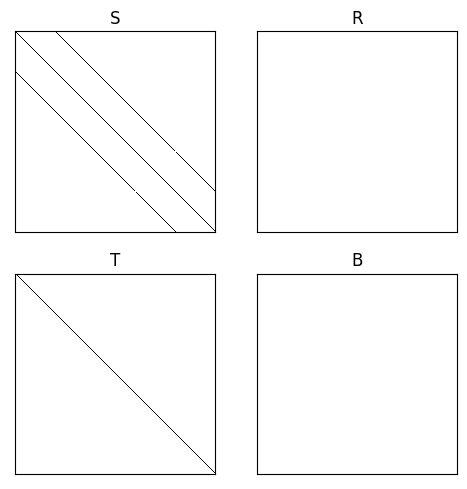

In [8]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [9]:
function voltage(t)
    10sin(2π*2e8*t)
end

function assemble_circuit!(i, didv, v, t)
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == DOF_CIR_R1
            i[jj] = v[jj] * 1.0 / R1
            didv[jj, jj] =  1.0 / R1
        end
        if Γ[ii] == DOF_CIR_D1
            i[jj] = I0 * (exp(v[jj]/Vt) - 1.0)
            didv[jj, jj] = I0/Vt * exp(v[jj]/Vt)
        end

        if Γ[ii] == DOF_SRC
            i[jj] = v[jj] * 1.0 / Rc * 2.0 + voltage(t) / Rc
            didv[jj, jj] =  1.0 / Rc * 2.0
        end

        if Γ[ii] == DOF_END
            i[jj] = v[jj] * 1.0 / Rc * 2.0
            didv[jj, jj] =  1.0 / Rc * 2.0
        end
    end
end

assemble_circuit! (generic function with 1 method)

In [10]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [11]:
x = 0.010:0.050:0.510
y = 0.005:0.002:0.015
xx, yy = meshgrid(x, y);

it  = 1
nt  = 1600
t   = 0.00
i   = zeros(NUM_EDGES)
ip  = zeros(NUM_EDGES)
ipp = zeros(NUM_EDGES)
e   = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vol = zeros(nt)
cur = zeros(nt)

didv = spzeros(NUM_EDGES, NUM_EDGES)
nothing

In [12]:
N = 0
Δe = similar(e)

@elapsed for _ = it:nt
    b = (0.50Δt^2 * S - 2T) * ep + (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp
    
    fill!(Δe, Inf)
    #fill!(e,  0.0)
    while norm(Δe) > 1e-12 && N < 10
        assemble_circuit!(i, didv, e, t)
        Fi = A*e + 0.5Δt * ly^2 * μ0 * i - 0.5Δt * ly^2 * μ0 * ipp + b
        Ji = A   + 0.5Δt * ly^2 * μ0 * didv
        Δe .= Ji\Fi
        e .-= Δe
        #println("[nonlinear] |Δe| = $(norm(Δe))")
        N += 1
    end
    println("[linear] $it [nonlinear] converged in $N iterations with $(norm(Δe))")
    N = 0
    epp .= ep
    ep  .= e

    ipp .= ip
    ip  .= i
    
    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vol[it] = sum(-e[dof[Γ .== DOF_CIR_D1]])
    cur[it] = sum( i[dof[Γ .== DOF_CIR_D1]])
    it += 1
    t  += Δt
end

[linear] 1 [nonlinear] converged in 1 iterations with 0.0
[linear] 2 [nonlinear] converged in 2 iterations with 1.0323009891856747e-18
[linear] 3 [nonlinear] converged in 2 iterations with 4.7026561422658445e-18
[linear] 4 [nonlinear] converged in 2 iterations with 3.2223011681670496e-17
[linear] 5 [nonlinear] converged in 2 iterations with 1.6154633701610236e-17
[linear] 6 [nonlinear] converged in 2 iterations with 1.832530913144162e-17
[linear] 7 [nonlinear] converged in 2 iterations with 3.240726682310425e-17
[linear] 8 [nonlinear] converged in 2 iterations with 5.093316626464963e-17
[linear] 9 [nonlinear] converged in 2 iterations with 7.815445977694265e-17
[linear] 10 [nonlinear] converged in 2 iterations with 6.786768349007217e-17
[linear] 11 [nonlinear] converged in 2 iterations with 1.0671290893009428e-16
[linear] 12 [nonlinear] converged in 2 iterations with 1.5483946680157578e-16
[linear] 13 [nonlinear] converged in 2 iterations with 5.857901536192292e-17
[linear] 14 [nonline

[linear] 133 [nonlinear] converged in 2 iterations with 5.746139797372999e-15
[linear] 134 [nonlinear] converged in 2 iterations with 5.615541143947537e-15
[linear] 135 [nonlinear] converged in 2 iterations with 4.194056658923433e-15
[linear] 136 [nonlinear] converged in 2 iterations with 4.012162428783876e-15
[linear] 137 [nonlinear] converged in 2 iterations with 3.3427562553179553e-15
[linear] 138 [nonlinear] converged in 2 iterations with 3.747409226983395e-15
[linear] 139 [nonlinear] converged in 2 iterations with 3.454162770047343e-15
[linear] 140 [nonlinear] converged in 2 iterations with 3.4168998019871304e-15
[linear] 141 [nonlinear] converged in 2 iterations with 3.84836715747172e-15
[linear] 142 [nonlinear] converged in 2 iterations with 2.8889369876279727e-15
[linear] 143 [nonlinear] converged in 2 iterations with 3.98368966135895e-15
[linear] 144 [nonlinear] converged in 2 iterations with 3.1970760703636663e-15
[linear] 145 [nonlinear] converged in 2 iterations with 3.7431

[linear] 257 [nonlinear] converged in 2 iterations with 4.085385323336057e-15
[linear] 258 [nonlinear] converged in 2 iterations with 3.916139601009563e-15
[linear] 259 [nonlinear] converged in 2 iterations with 3.712312490606303e-15
[linear] 260 [nonlinear] converged in 2 iterations with 4.650981869066264e-15
[linear] 261 [nonlinear] converged in 2 iterations with 5.3808729646601915e-15
[linear] 262 [nonlinear] converged in 2 iterations with 4.37485291902567e-15
[linear] 263 [nonlinear] converged in 2 iterations with 4.3014229519364885e-15
[linear] 264 [nonlinear] converged in 2 iterations with 4.040681884162863e-15
[linear] 265 [nonlinear] converged in 2 iterations with 3.7882039875232225e-15
[linear] 266 [nonlinear] converged in 2 iterations with 4.943568695423159e-15
[linear] 267 [nonlinear] converged in 2 iterations with 4.727498372639922e-15
[linear] 268 [nonlinear] converged in 2 iterations with 5.2619395557882595e-15
[linear] 269 [nonlinear] converged in 2 iterations with 4.829

[linear] 397 [nonlinear] converged in 4 iterations with 2.542899037717951e-15
[linear] 398 [nonlinear] converged in 4 iterations with 2.1893325368755175e-15
[linear] 399 [nonlinear] converged in 5 iterations with 2.509356302503933e-15
[linear] 400 [nonlinear] converged in 6 iterations with 2.316045594718852e-15
[linear] 401 [nonlinear] converged in 5 iterations with 1.1211701015846358e-13
[linear] 402 [nonlinear] converged in 5 iterations with 2.3479035068203067e-15
[linear] 403 [nonlinear] converged in 5 iterations with 2.641571308747352e-15
[linear] 404 [nonlinear] converged in 5 iterations with 2.316324275633027e-15
[linear] 405 [nonlinear] converged in 5 iterations with 2.8108246658391537e-15
[linear] 406 [nonlinear] converged in 4 iterations with 4.022409835365532e-13
[linear] 407 [nonlinear] converged in 4 iterations with 2.1863097023037142e-14
[linear] 408 [nonlinear] converged in 4 iterations with 5.048079741917915e-15
[linear] 409 [nonlinear] converged in 4 iterations with 4.6

[linear] 553 [nonlinear] converged in 4 iterations with 1.721494420200042e-15
[linear] 554 [nonlinear] converged in 4 iterations with 1.7698581176831026e-15
[linear] 555 [nonlinear] converged in 4 iterations with 1.587203969877129e-15
[linear] 556 [nonlinear] converged in 4 iterations with 1.9737039921500954e-15
[linear] 557 [nonlinear] converged in 4 iterations with 1.7326851245092868e-15
[linear] 558 [nonlinear] converged in 4 iterations with 1.612699407135096e-15
[linear] 559 [nonlinear] converged in 4 iterations with 2.111682605016466e-15
[linear] 560 [nonlinear] converged in 4 iterations with 1.644325598809567e-15
[linear] 561 [nonlinear] converged in 4 iterations with 1.4529828810274691e-15
[linear] 562 [nonlinear] converged in 4 iterations with 2.6593198666624897e-15
[linear] 563 [nonlinear] converged in 4 iterations with 2.3050910403701907e-15
[linear] 564 [nonlinear] converged in 4 iterations with 1.9846458509408255e-15
[linear] 565 [nonlinear] converged in 4 iterations with 1

[linear] 695 [nonlinear] converged in 2 iterations with 4.616451760574496e-15
[linear] 696 [nonlinear] converged in 2 iterations with 5.038094874658958e-15
[linear] 697 [nonlinear] converged in 2 iterations with 4.652504718683757e-15
[linear] 698 [nonlinear] converged in 2 iterations with 4.4193610831056585e-15
[linear] 699 [nonlinear] converged in 2 iterations with 5.244028643837801e-15
[linear] 700 [nonlinear] converged in 2 iterations with 4.042574610991264e-15
[linear] 701 [nonlinear] converged in 2 iterations with 4.751726668368318e-15
[linear] 702 [nonlinear] converged in 2 iterations with 4.256404164020626e-15
[linear] 703 [nonlinear] converged in 2 iterations with 4.5839905628342026e-15
[linear] 704 [nonlinear] converged in 2 iterations with 4.440743903408327e-15
[linear] 705 [nonlinear] converged in 2 iterations with 3.998790469704904e-15
[linear] 706 [nonlinear] converged in 2 iterations with 4.2507015033875036e-15
[linear] 707 [nonlinear] converged in 2 iterations with 4.350

[linear] 803 [nonlinear] converged in 2 iterations with 4.411388517479346e-15
[linear] 804 [nonlinear] converged in 2 iterations with 4.355696149467877e-15
[linear] 805 [nonlinear] converged in 2 iterations with 4.529919364785331e-15
[linear] 806 [nonlinear] converged in 2 iterations with 3.891731793314514e-15
[linear] 807 [nonlinear] converged in 2 iterations with 4.2182526655239825e-15
[linear] 808 [nonlinear] converged in 2 iterations with 5.2609533224631565e-15
[linear] 809 [nonlinear] converged in 2 iterations with 3.986132336589234e-15
[linear] 810 [nonlinear] converged in 2 iterations with 4.4575445206313114e-15
[linear] 811 [nonlinear] converged in 2 iterations with 4.7518255185172805e-15
[linear] 812 [nonlinear] converged in 2 iterations with 4.396628312539423e-15
[linear] 813 [nonlinear] converged in 2 iterations with 4.930096135989359e-15
[linear] 814 [nonlinear] converged in 2 iterations with 5.061057828518779e-15
[linear] 815 [nonlinear] converged in 2 iterations with 5.00

[linear] 923 [nonlinear] converged in 4 iterations with 2.505426403996631e-15
[linear] 924 [nonlinear] converged in 4 iterations with 2.098922373131586e-15
[linear] 925 [nonlinear] converged in 4 iterations with 2.6141585237392505e-15
[linear] 926 [nonlinear] converged in 4 iterations with 2.539272076197637e-15
[linear] 927 [nonlinear] converged in 4 iterations with 2.691739161388916e-15
[linear] 928 [nonlinear] converged in 4 iterations with 2.4201909140321744e-15
[linear] 929 [nonlinear] converged in 4 iterations with 3.91716178134842e-15
[linear] 930 [nonlinear] converged in 4 iterations with 2.2373596877691193e-15
[linear] 931 [nonlinear] converged in 4 iterations with 2.8359216903523536e-15
[linear] 932 [nonlinear] converged in 4 iterations with 2.3429481642043287e-15
[linear] 933 [nonlinear] converged in 4 iterations with 2.850271801933945e-15
[linear] 934 [nonlinear] converged in 4 iterations with 2.683773298084771e-15
[linear] 935 [nonlinear] converged in 4 iterations with 2.82

[linear] 1049 [nonlinear] converged in 4 iterations with 1.094589830722098e-15
[linear] 1050 [nonlinear] converged in 4 iterations with 1.828487330791579e-15
[linear] 1051 [nonlinear] converged in 4 iterations with 1.9723842983865463e-15
[linear] 1052 [nonlinear] converged in 4 iterations with 1.589376057517447e-15
[linear] 1053 [nonlinear] converged in 4 iterations with 1.7163671282395426e-15
[linear] 1054 [nonlinear] converged in 4 iterations with 1.5516576499393706e-15
[linear] 1055 [nonlinear] converged in 4 iterations with 1.628833430251631e-15
[linear] 1056 [nonlinear] converged in 4 iterations with 1.898267861408071e-15
[linear] 1057 [nonlinear] converged in 4 iterations with 2.0141802748004536e-15
[linear] 1058 [nonlinear] converged in 4 iterations with 1.5598215255415241e-15
[linear] 1059 [nonlinear] converged in 4 iterations with 1.5410423479960267e-15
[linear] 1060 [nonlinear] converged in 4 iterations with 1.927991119670323e-15
[linear] 1061 [nonlinear] converged in 4 itera

[linear] 1207 [nonlinear] converged in 2 iterations with 3.967884086660958e-15
[linear] 1208 [nonlinear] converged in 2 iterations with 3.473759106210147e-15
[linear] 1209 [nonlinear] converged in 2 iterations with 4.56951029833305e-15
[linear] 1210 [nonlinear] converged in 2 iterations with 4.910257649656171e-15
[linear] 1211 [nonlinear] converged in 2 iterations with 4.575297370588078e-15
[linear] 1212 [nonlinear] converged in 2 iterations with 4.600303413400006e-15
[linear] 1213 [nonlinear] converged in 2 iterations with 4.856450051899777e-15
[linear] 1214 [nonlinear] converged in 2 iterations with 4.3668561602076235e-15
[linear] 1215 [nonlinear] converged in 2 iterations with 4.582746107677295e-15
[linear] 1216 [nonlinear] converged in 2 iterations with 4.3312987607353756e-15
[linear] 1217 [nonlinear] converged in 2 iterations with 5.5439051013846046e-15
[linear] 1218 [nonlinear] converged in 2 iterations with 4.8375284195043325e-15
[linear] 1219 [nonlinear] converged in 2 iteratio

[linear] 1351 [nonlinear] converged in 2 iterations with 4.642941030962298e-15
[linear] 1352 [nonlinear] converged in 2 iterations with 5.103726906191375e-15
[linear] 1353 [nonlinear] converged in 2 iterations with 4.191519888102861e-15
[linear] 1354 [nonlinear] converged in 2 iterations with 5.512513046144494e-15
[linear] 1355 [nonlinear] converged in 2 iterations with 5.548869495398952e-15
[linear] 1356 [nonlinear] converged in 2 iterations with 5.334580779378278e-15
[linear] 1357 [nonlinear] converged in 2 iterations with 4.468790165972245e-15
[linear] 1358 [nonlinear] converged in 2 iterations with 5.044089522934742e-15
[linear] 1359 [nonlinear] converged in 2 iterations with 5.299440598760506e-15
[linear] 1360 [nonlinear] converged in 2 iterations with 5.343023422479495e-15
[linear] 1361 [nonlinear] converged in 2 iterations with 4.909367575664374e-15
[linear] 1362 [nonlinear] converged in 2 iterations with 5.0113454140369315e-15
[linear] 1363 [nonlinear] converged in 2 iterations

[linear] 1463 [nonlinear] converged in 4 iterations with 1.5195254013138509e-15
[linear] 1464 [nonlinear] converged in 4 iterations with 2.4861347286808084e-15
[linear] 1465 [nonlinear] converged in 4 iterations with 2.2689630468521053e-15
[linear] 1466 [nonlinear] converged in 4 iterations with 2.4658714198032334e-15
[linear] 1467 [nonlinear] converged in 4 iterations with 2.2347910861077054e-15
[linear] 1468 [nonlinear] converged in 4 iterations with 2.170261110609645e-15
[linear] 1469 [nonlinear] converged in 4 iterations with 1.876172744036942e-15
[linear] 1470 [nonlinear] converged in 4 iterations with 2.0740057992325377e-15
[linear] 1471 [nonlinear] converged in 4 iterations with 1.807331938738443e-15
[linear] 1472 [nonlinear] converged in 4 iterations with 1.6628061695280044e-15
[linear] 1473 [nonlinear] converged in 4 iterations with 2.1997491518233337e-15
[linear] 1474 [nonlinear] converged in 4 iterations with 1.826420406237136e-15
[linear] 1475 [nonlinear] converged in 4 ite

[linear] 1585 [nonlinear] converged in 4 iterations with 3.0302593600647128e-15
[linear] 1586 [nonlinear] converged in 4 iterations with 1.7455878395776973e-15
[linear] 1587 [nonlinear] converged in 4 iterations with 2.2120050315308674e-15
[linear] 1588 [nonlinear] converged in 4 iterations with 2.929829129376017e-15
[linear] 1589 [nonlinear] converged in 4 iterations with 1.8310916725918507e-15
[linear] 1590 [nonlinear] converged in 4 iterations with 1.960439629031066e-15
[linear] 1591 [nonlinear] converged in 4 iterations with 2.734914286083213e-15
[linear] 1592 [nonlinear] converged in 4 iterations with 3.533741828408977e-15
[linear] 1593 [nonlinear] converged in 4 iterations with 2.6976855574647303e-15
[linear] 1594 [nonlinear] converged in 4 iterations with 2.732498152345038e-15
[linear] 1595 [nonlinear] converged in 4 iterations with 2.9870074366770134e-15
[linear] 1596 [nonlinear] converged in 4 iterations with 2.627331007205724e-15
[linear] 1597 [nonlinear] converged in 4 itera

10.63606997

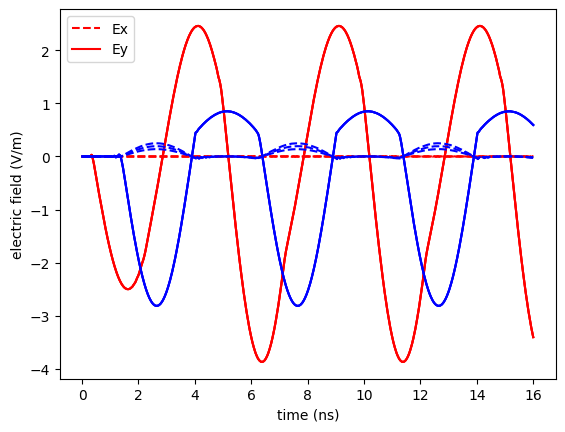

PyObject <matplotlib.legend.Legend object at 0x13aeec290>

In [13]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 1], "r--", ts, res[:, 3, 1, 2], "r-")
plot(ts, res[:, 3, 2, 1], "r--", ts, res[:, 3, 2, 2], "r-")
plot(ts, res[:, 3, 3, 1], "r--", ts, res[:, 3, 3, 2], "r-")
plot(ts, res[:, 9, 1, 1], "b--", ts, res[:, 9, 1, 2], "b-")
plot(ts, res[:, 9, 2, 1], "b--", ts, res[:, 9, 2, 2], "b-")
plot(ts, res[:, 9, 3, 1], "b--", ts, res[:, 9, 3, 2], "b-")
xlabel("time (ns)")
ylabel("electric field (V/m)")
legend(["Ex", "Ey"])


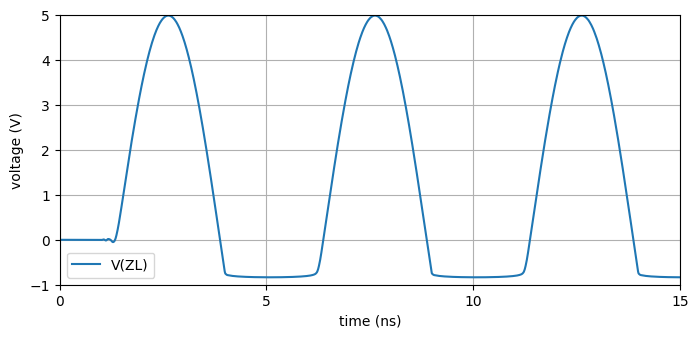

In [14]:
ts = 1e9Δt * collect(1:nt)
figure(figsize=(8, 3.5))
grid()
plot(ts, vol)
xlabel("time (ns)")
ylabel("voltage (V)")
legend(["V(ZL)"])
xticks(0:5:15), xlim((0, 15))
yticks(-1:5),   ylim((-1, 5))
nothing

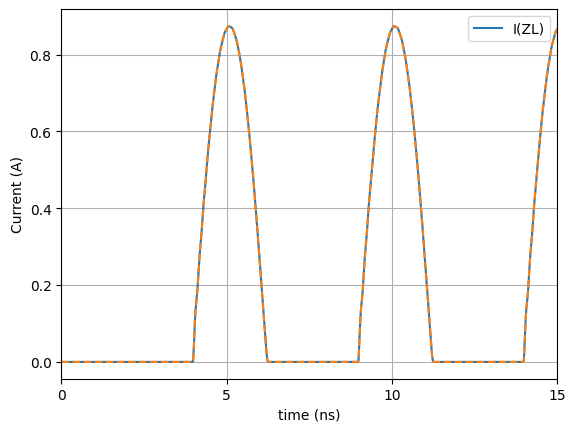

In [15]:
ts = 1e9Δt * collect(1:nt)
id = @. I0 * (exp(-vol/Vt) - 1.0)
grid()
plot(ts, cur)
plot(ts, id, "--")
xlabel("time (ns)")
ylabel("Current (A)")
legend(["I(ZL)"])
xticks(0:5:15), xlim((0, 15))
nothing